In [1]:
# %reload_ext autoreload
# %autoreload 2
# %matplotlib inline

# from __core__ import *
# from __utils__ import *

# from __models__ import *
# from __train__ import *
# from functools  import partial
# import warnings; warnings.filterwarnings('ignore')

In [79]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from torch import nn
from torch.nn import functional as F
from pathlib import Path
from __dataBatches__ import *
import warnings; warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score

# MURA Pretrained

In [35]:
pretrained = True
batch_size = 16
epochs = 8
freeze = False

random_states = [42]

PATH = Path('../data')
SAVE_DIRECTORY = Path('../latest_models/chest')
SAVE_PLOT = Path('../latest_plots/chest')

img_folder_path = PATH/'ChestXRay-250'
data = 'chest'

# Data Batch creation

In [36]:
train_df = pd.read_csv(PATH/"train_df.csv")
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")


train_dl = DataBatches(train_df, img_folder_path=img_folder_path,
                               transforms=True, shuffle=True, data=data,
                               batch_size=batch_size, normalize=pretrained)

valid_dl = DataBatches(valid_df,img_folder_path=img_folder_path,
                     transforms = False, shuffle = False, data= data,
                     batch_size = batch_size, normalize=pretrained)

test_dl = DataBatches(test_df,img_folder_path=img_folder_path,
                  transforms = True, shuffle = False, data=data,
                  batch_size = batch_size, normalize=pretrained)


In [37]:
train_dl.set_random_choices()

In [38]:
x,y = next(iter(train_dl))

In [39]:
x.shape, y.shape

(torch.Size([16, 3, 234, 234]), torch.Size([16, 14]))

In [40]:
x,y = next(iter(valid_dl))

In [41]:
x.shape, y.shape

(torch.Size([16, 3, 234, 234]), torch.Size([16, 14]))

# Architecture

In [42]:
def save_model(m, p): torch.save(m.state_dict(), p)


def load_model(m, p): m.load_state_dict(torch.load(p))


def get_top_layers(pretrained):
    '''Return a list of the top groups of paramteres. 
    Handles cases when:
    > Model structure is in sequential groups (MURA)
    > Model structure is the default from densenet121 architecture
    '''
    if pretrained == 'MURA':
        top = DenseNet(1, False)
        load_model(top, '../latest_models/mura_2.pth')
        out = list([group.children() for group in top.groups[:2]])
    elif pretrained in (True, False):
        top_model = models.densenet121(pretrained=pretrained)
        top_layers = list(top_model.children())[0]
        out = [top_layers[:7], top_layers[7:]]
    else:
        raise ValueError("Invalid pretrained value")
        
    return out

class DenseNet(nn.Module):
    '''
    DenseNet121 with quick iterations on:
     > arbitrary finite out_size.
     > pre-trained model between ImageNet and the medical image data-set MURA (all but last layer).
     > half float precision (16)
     > freeze layers
    '''

    def __init__(self, out_size: int = 14, pretrained: bool = False, freeze: str = False):
        '''

        :param out_size: (int) output size
        :param pretrained: (bool/str) Kind of pre-train: Supports  'MURA', True and False.
        :param freeze: (bool) freeze all layers but last one.
        '''
        super().__init__()

        top_layers_groups = get_top_layers(pretrained)

        self.groups = nn.ModuleList([nn.Sequential(*group) for group in top_layers_groups])
        self.groups.append(nn.Linear(1024, out_size))

        if freeze: self.freeze([0, 1])

    def forward(self, x):

        for group in self.groups[:-1]:
            x = group(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = x.view(x.shape[0], -1)
        x = self.groups[-1](x)
        return x

    def freeze(self, group_idxs: (list,int,tuple)):
        if not isinstance(group_idxs, (list, tuple)): group_idxs = [group_idxs]
        for group_idx in group_idxs:
            group = self.groups[group_idx]
            parameters = filter(lambda x: x.requires_grad, group.parameters())
            for p in parameters:
                p.requires_grad = False

    def unfreeze(self, group_idx: int):
        if group_idx not in [0, 1, 2]: raise ValueError('group_idx must be between 0 and 2')
        group = self.groups[group_idx]
        parameters = filter(lambda x: hasattr(x, 'requires_grad'), group.parameters())
        for p in parameters: p.requires_grad = True

In [43]:
# model = DenseNet(14, pretrained=pretrained, freeze=False).cuda()

# LR Finder

In [44]:
list(range(2,-1,-1))

[2, 1, 0]

In [55]:
### Annealings ###

def exp_annealing(start_lr, end_lr, n):
    ptg = np.linspace(0, 1, n)
    return start_lr * (end_lr / start_lr) ** ptg

def cos_annealing(start_lr, end_lr, n_iterations):
    i = np.arange(n_iterations)
    c_i = 1 + np.cos(i * np.pi / n_iterations)
    return end_lr + (start_lr - end_lr) / 2 * c_i

### Diff lr ###

def diff_range(val, alpha=1.3):
    return [val*alpha**i for i in range(2,-1,-1)]

##### LR finder : Plicy, Optimizer and 
class FinderPolicy:

    def __init__(self, n_epochs, dl, min_lr=1e-7, max_lr=10):
        '''
        Implements exponential annealing policy from min_lr to max_lr
        '''
        total_iterations = n_epochs * len(dl)
        self.lr_schedule = exp_annealing(min_lr, max_lr, total_iterations)
        self.mom = .9 # constant momentum policy with default value
        self.idx = -1

    def step(self):
        self.idx = self.idx + 1
        return self.lr_schedule[self.idx], self.mom
    
    
class TrainingPolicy:
    '''Cretes the lr and momentum policy'''
    
    def __init__(self, n_epochs, dl, max_lr, pctg=.3, moms=(.95, .85),
                 delta=1e-4, div_factor=25.):

        total_iterations = n_epochs * len(dl)
        
        iter1 = int(total_iterations * pctg)
        iter2 = total_iterations - int(total_iterations * pctg)
        iterations = (iter1, iter2)
        
        
        min_start = max_lr /div_factor
        min_end = min_start*delta
        
        lr_segments = ((min_start, max_lr), (max_lr, min_end))
        mom_segments = (moms, (moms[1], moms[0]))

        self.lr_schedule = self._create_schedule(lr_segments, iterations)
        self.mom_schedule = self._create_schedule(mom_segments, iterations)

        self.idx = -1

    def _create_schedule(self, segments, iterations):
        '''
        Creates a schedule given a function, behaviour and size
        '''
        stages = [cos_annealing(start, end, n) for ((start, end), n) in zip(segments, iterations)]
        return np.concatenate(stages)

    def step(self):
        self.idx += 1
        return self.lr_schedule[self.idx], self.mom_schedule[self.idx]
        
class OptimizerWrapper:
    '''Without using the momentum policy'''
    
    def __init__(self, model, policy, wd=0, alpha=1./ 3):

        self.policy = policy # TrainingPolicy(n_epochs=n_epochs, dl=dl, max_lr=max_lr)

        self.model = model
        self.alpha = alpha
        self.wd = wd
        
        # This assumes the model is defined by groups.
        param_groups = [group.parameters() for group in list(self.model.children())[0]]
        lr_0 = self.policy.lr_schedule[0]
        mom_0 = self.policy.mom_schedule[0] if hasattr(self.policy, 'mom_schedule') else .9
        
        groups = zip(param_groups, diff_range(lr_0, alpha=alpha), diff_range(mom_0, alpha=1))
        
        self.optimizer = optim.Adam(
            [{'params': p, 'lr': lr, 'mom': (mom,.999)} for p, lr, mom in groups]
        )

    def _update_optimizer(self):
        lr_i, mom_i = self.policy.step()
        groups = zip(self.optimizer.param_groups, 
                     diff_range(lr_i, alpha=self.alpha), 
                     diff_range(mom_i, alpha=1))
        
        for param_group, lr, mom in groups:
            param_group['lr'] = lr
            param_group['mom'] = (mom,.999)
        
    def _weight_decay(self):
        for group in self.optimizer.param_group:
                for p in group['params']: p.data.mul_(group['lr'] * self.wd)
        
    def step(self):
        self._update_optimizer()
        if self.wd != 0: self._weight_decay()
        self.optimizer.step()

    def zero_grad(self):
        self.optimizer.zero_grad()

# LR finder loop
def lr_finder(model, n_epochs, train_dl, min_lr=1e-7, max_lr=10, save_path=None,
              mode='exponential', early_stopping=200):

    if save_path: save_model(model, save_path)
    model.train()
    
    policy = FinderPolicy(n_epochs=n_epochs, dl=train_dl, min_lr=min_lr, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy)

    lrs = optimizer.policy.lr_schedule
    
    losses = []
    cnt = 0

    for _ in tqdm_notebook(range(n_epochs)):
        train_dl.set_random_choices()
        for it, (x, y) in enumerate(tqdm_notebook(train_dl)):

            optimizer.zero_grad()

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if it%200 == 199:
                plt.plot(lrs[:len(losses)], losses)
                plt.xticks(rotation=45)
                plt.show()

            if cnt==early_stopping: return lrs[:cnt], losses
            cnt +=1

    if save_path: load_model(model, p)

    return lrs, losses

In [ ]:
def lr_finder(model, n_epochs, train_dl, min_lr=1e-7, max_lr=10, save_path=None,
              mode='exponential', early_stopping=200):

    if save_path: save_model(model, save_path)

    optimizer = FinderOptimizerWrapper(model, n_epochs, train_dl, min_lr=min_lr, max_lr=max_lr, wd=0, mode=mode)

    lrs = optimizer.policy.lr_schedule
    losses = []
    cnt = 0

    for _ in tqdm_notebook(range(n_epochs)):
        model.train()
        train_dl.set_random_choices()
        for it, (x, y) in enumerate(tqdm_notebook(train_dl)):

            optimizer.zero_grad()

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if it%200 == 199:
                plt.plot(lrs[:len(losses)], losses)
                plt.xticks(rotation=45)
                plt.show()

            if cnt==early_stopping: return lrs[:cnt], losses
            cnt +=1

    if save_path: load_model(model, p)

    return lrs, losses

A Jupyter Widget

A Jupyter Widget

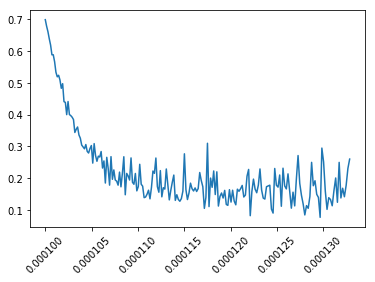

In [54]:
model = DenseNet(14, pretrained=pretrained, freeze=False).cuda()
lrs, losses  = lr_finder(model, 1, train_dl, min_lr=1e-4, max_lr=1e-1, early_stopping=200)

# Training definitions

In [62]:
def compute_AUCs(y, pred):
    AUROCs = []
    for i in range(N_CLASSES):
        auc_i = roc_auc_score(y[:, i].astype(int), pred[:, i])
        AUROCs.append(auc_i)
    return  np.mean(AUROCs)

def ave_auc(probs, ys):
    aucs = [roc_auc_score(ys[:,i], probs[:,i]) for i in range(probs.shape[1])]
    return np.mean(aucs), aucs   


def validate(model, valid_dl):
    
    model.eval()
    total = 0
    sum_loss = 0
    ys = []
    preds = []
    
    for x, y in valid_dl:
        
        out = model(x)
        loss = F.binary_cross_entropy_with_logits(out, y)
        
        batch = y.shape[0]
        sum_loss += batch * (loss.item())
        total += batch
        
        preds.append( out.detach().cpu().numpy())
        ys.append( y.long().cpu().numpy())

 
        
    preds = np.vstack(preds)
    ys = np.vstack(ys)
    mean_auc, aucs = ave_auc(preds, ys)
    
#     print('\n'.join([f'{m:.3f}' for m in auc])+'\n')
    
    return sum_loss / total, mean_auc, aucs

def train(n_epochs, train_dl, valid_dl, model, div_factor=25., max_lr=.01, wd=0, alpha=1./ 3,
          save_path=None, unfreeze_during_loop:tuple=None):
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])

    best_loss = np.inf
    
    policy = TrainingPolicy(n_epochs=n_epochs, dl=train_dl, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy, wd=wd, alpha=alpha)

    for epoch in tqdm_notebook(range(n_epochs), ):
        model.train()
        agg_div = 0
        agg_loss = 0
        train_dl.set_random_choices()
        for i, (x, y) in enumerate(tqdm_notebook(train_dl, leave=False)):

            if unfreeze_during_loop:
                if i == first_unfreeze: model.unfreeze(1)
                if i == second_unfreeze: model.unfreeze(0)

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            agg_loss += batch*loss.item()
            agg_div += batch


        val_loss, measure, _ = validate(model, valid_dl)
        print(f'Ep. {epoch+1} - train loss {agg_loss/agg_div:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if save_path and val_loss < best_loss:
            save_model(model, save_path)
            best_loss = val_loss

# Training

In [68]:
epochs = 8

In [67]:
# tiny version

N  = 2_000
tiny_df = train_df[:N]
transforms=[random_rotation(arc_width=20), filp(), random_crop(r_pix=8)]
tiny_dl = DataBatches(tiny_df, img_folder_path=img_folder_path,
                               transforms=transforms, shuffle=True, data=data,
                               batch_size=batch_size, normalize=pretrained)

model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()

train(epochs, tiny_dl, valid_dl, model, max_lr=.001, save_path=None, unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.2881 -  val loss 0.1628 AUC 0.6458


A Jupyter Widget

Ep. 2 - train loss 0.1509 -  val loss 0.1610 AUC 0.6857


A Jupyter Widget

Ep. 3 - train loss 0.1426 -  val loss 0.1681 AUC 0.6922


A Jupyter Widget

Ep. 4 - train loss 0.1292 -  val loss 0.1663 AUC 0.7042


A Jupyter Widget

Ep. 5 - train loss 0.1141 -  val loss 0.1712 AUC 0.6959


A Jupyter Widget

Ep. 6 - train loss 0.0938 -  val loss 0.1743 AUC 0.7089


A Jupyter Widget

Ep. 7 - train loss 0.0746 -  val loss 0.1814 AUC 0.7055


A Jupyter Widget

Ep. 8 - train loss 0.0628 -  val loss 0.1810 AUC 0.7026


In [70]:
# tiny version

class random_rotation_v2:
    """ Rotates an image by deg degrees

    Args: -
    """

    def __init__(self): pass

    def __call__(self, im, deg,
                 mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
        r, c, *_ = im.shape
        M = cv2.getRotationMatrix2D((c / 2, r / 2), deg, 1)
        return cv2.warpAffine(im, M, (c, r), borderMode=mode,
                              flags=cv2.WARP_FILL_OUTLIERS + interpolation)

    def options(self, x_shape):
        """Specify the random arguments to be generated every epoch.
        Images must be have same dimensions !
        """
        return {"deg": -1}

    def set_random_choices(self, N, x_shape):
        return {k: np.random.choice([-90,0,90], size=N, replace=True)  for k, v in self.options(x_shape).items()}


N  = 2_000
tiny_df = train_df[:N]
transforms=[random_rotation_v2(), random_rotation(arc_width=20), flip(), random_crop(r_pix=8)]
tiny_dl = DataBatches(tiny_df, img_folder_path=img_folder_path,
                               transforms=transforms, shuffle=True, data=data,
                               batch_size=batch_size, normalize=pretrained)

model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()

train(epochs, tiny_dl, valid_dl, model, max_lr=.001, save_path=None, unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.3406 -  val loss 0.1666 AUC 0.6493


A Jupyter Widget

Ep. 2 - train loss 0.1556 -  val loss 0.1735 AUC 0.6702


A Jupyter Widget

Ep. 3 - train loss 0.1525 -  val loss 0.1693 AUC 0.6736


A Jupyter Widget

Ep. 4 - train loss 0.1434 -  val loss 0.1644 AUC 0.6954


A Jupyter Widget

Ep. 5 - train loss 0.1352 -  val loss 0.1689 AUC 0.7035


A Jupyter Widget

Ep. 6 - train loss 0.1261 -  val loss 0.1664 AUC 0.6972


A Jupyter Widget

Ep. 7 - train loss 0.1152 -  val loss 0.1659 AUC 0.7107


A Jupyter Widget

Ep. 8 - train loss 0.1098 -  val loss 0.1655 AUC 0.7091


In [ ]:
# Whole dataset

transforms=[random_rotation(arc_width=20), flip(), random_crop(r_pix=8)]

train_dl = DataBatches(train_df, img_folder_path=img_folder_path,transforms=transforms,
                       shuffle=True, data=data, batch_size=batch_size, normalize=pretrained)

model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()

train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=None, unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.1539 -  val loss 0.1467 AUC 0.7846


A Jupyter Widget

Ep. 2 - train loss 0.1402 -  val loss 0.1474 AUC 0.7900


A Jupyter Widget

Ep. 3 - train loss 0.1379 -  val loss 0.1452 AUC 0.7984


A Jupyter Widget

Ep. 4 - train loss 0.1339 -  val loss 0.1426 AUC 0.8193


A Jupyter Widget

In [ ]:
test_dl = DataBatches(test_df,img_folder_path=img_folder_path, transforms = True, 
                      shuffle = False, data=data, batch_size = batch_size, normalize=pretrained)
TTA_multilabel(model, test_dl)

In [ ]:
train_df = train_df.sample(frac=1)

for N in [50, 100, 5_000, 10_000, 20_000, 35_000, 50_000, 60_000, 77_880]:
    
    sampled_train_df = train_df[:N]
    
    train_dl = DataBatches(train_df, img_folder_path=img_folder_path,
                           transforms=True, shuffle=True, data=data,
                           batch_size=batch_size, half=False, normalize=pretrained)
    
    model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()
    save_path = SAVE_DIRECTORY/f"{pretrained}-{N}.pth"
    # save_path = SAVE_DIRECTORY / f"{pretrained}-{N}-{random_state}-unfreezing.pth"
    train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=save_path,unfreeze_during_loop=(.1, .2) if freeze else None)

In [20]:
test_dl = DataBatches(test_df,img_folder_path=img_folder_path,
                  transforms = False, shuffle = False, data=data,
                  batch_size = batch_size, normalize=pretrained)
validate(model, test_dl)

(0.20191780040408833,
 0.8164163548894331,
 [0.7777638937179043,
  0.8882716944725164,
  0.8331421478637311,
  0.6839344107757633,
  0.8366145269199207,
  0.7661666072832656,
  0.7252368098300768,
  0.8640024568362074,
  0.752993899915239,
  0.8507316063175169,
  0.9233914222053733,
  0.8275160380939851,
  0.7879706132917902,
  0.9120928409287741])

In [22]:
test_dl = DataBatches(test_df,img_folder_path=img_folder_path,
                  transforms = True, shuffle = False, data=data,
                  batch_size = batch_size, normalize=pretrained)
TTA_test_metrics_chest(model, test_dl)

val loss 0.2021 and auc 0.8210


(0.20208021653882324, 0.8209861720227334)

In [18]:
model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()
save_path = SAVE_DIRECTORY/f"{pretrained}-77800.pth"
# save_path = SAVE_DIRECTORY / f"{pretrained}-{N}-{random_state}-unfreezing.pth"
train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=save_path,unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.1535 -  val loss 0.1460 AUC 0.7735


A Jupyter Widget

Ep. 2 - train loss 0.1403 -  val loss 0.1490 AUC 0.7919


A Jupyter Widget

Ep. 3 - train loss 0.1379 -  val loss 0.1473 AUC 0.8027


A Jupyter Widget

Ep. 4 - train loss 0.1337 -  val loss 0.1427 AUC 0.8155


A Jupyter Widget

Ep. 5 - train loss 0.1295 -  val loss 0.1388 AUC 0.8338


A Jupyter Widget

Ep. 6 - train loss 0.1251 -  val loss 0.1369 AUC 0.8358


A Jupyter Widget

Ep. 7 - train loss 0.1200 -  val loss 0.1369 AUC 0.8411


A Jupyter Widget

IndexError: index 38728 is out of bounds for axis 0 with size 38728

In [215]:
model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()
save_path = SAVE_DIRECTORY/f"{pretrained}-77800-{random_state}.pth"
# save_path = SAVE_DIRECTORY / f"{pretrained}-{N}-{random_state}-unfreezing.pth"
train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=save_path, bar=tqdm_notebook,
      unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

Ep. 1 - train loss 0.1529 -  val loss 0.1456 AUC 0.7908
Ep. 2 - train loss 0.1445 -  val loss 0.1478 AUC 0.7804
Ep. 3 - train loss 0.1399 -  val loss 0.1457 AUC 0.7900
Ep. 4 - train loss 0.1356 -  val loss 0.1409 AUC 0.8095
Ep. 5 - train loss 0.1315 -  val loss 0.1398 AUC 0.8125
Ep. 6 - train loss 0.1269 -  val loss 0.1382 AUC 0.8219
Ep. 7 - train loss 0.1218 -  val loss 0.1373 AUC 0.8233
Ep. 8 - train loss 0.1178 -  val loss 0.1374 AUC 0.8250
